In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/n/groups/marks/users/erik/Promoter_Poet_private/data/generated_promoters.csv")
seqs = [] 

for i, row in df.iterrows():
    s = row.samples
    seqs.extend(s[1:-1].split(','))
    


In [8]:
q_path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/query.pkl"
with open(q_path, "rb") as f:
    queries = pickle.load(f)
queries = list(queries.values())

In [17]:
print(len(seqs[0]))

1001


In [6]:
def calculate_nucleotide_proportions(sequences, window=600):
        """Calculate position-specific nucleotide proportions around sequence center"""
        center = len(sequences[0]) // 2
        half_window = window // 2
        positions = range(-half_window, half_window)
        
        # Initialize data structure
        proportions = {
            'A': np.zeros(window),
            'C': np.zeros(window),
            'G': np.zeros(window),
            'T': np.zeros(window)
        }
        
        # Count nucleotides at each position
        for sequence in sequences:
            for i, pos in enumerate(range(center - half_window, center + half_window)):
                if 0 <= pos < len(sequence):
                    nucleotide = sequence[pos]
                    if nucleotide in proportions:
                        proportions[nucleotide][i] += 1
        
        # Convert to proportions
        total = len(sequences)
        for nucleotide in proportions:
            proportions[nucleotide] = proportions[nucleotide] / total
            
        return proportions, positions

In [14]:
model, _ = calculate_nucleotide_proportions(seqs)
gt, _ = calculate_nucleotide_proportions(queries)

In [20]:
# print(model)
print(model)

{'A': array([0.28275109, 0.27965793, 0.28074964, 0.27292576, 0.28093159,
       0.27347162, 0.2845706 , 0.27656477, 0.27747453, 0.2863901 ,
       0.2676492 , 0.28038574, 0.2845706 , 0.2661936 , 0.27638282,
       0.27438137, 0.27529112, 0.2665575 , 0.26892285, 0.27347162,
       0.27328967, 0.27547307, 0.28220524, 0.28147744, 0.27037846,
       0.28002183, 0.27747453, 0.27583697, 0.27110626, 0.28402475,
       0.27347162, 0.27183406, 0.28238719, 0.27401747, 0.26346434,
       0.27947598, 0.28202329, 0.27656477, 0.27147016, 0.2863901 ,
       0.2856623 , 0.268377  , 0.27165211, 0.27401747, 0.27820233,
       0.27729258, 0.26382824, 0.27219796, 0.28311499, 0.26855895,
       0.28147744, 0.28275109, 0.27747453, 0.27274381, 0.27529112,
       0.28311499, 0.26601164, 0.27456332, 0.29439592, 0.26310044,
       0.26200873, 0.27365357, 0.27747453, 0.28147744, 0.27401747,
       0.28056769, 0.28511645, 0.27638282, 0.27529112, 0.28147744,
       0.27692868, 0.27401747, 0.28129549, 0.27638282, 0

In [10]:
def plot_nucleotide_proportions(ref_proportions, model_proportions, positions):
        """
        Plot nucleotide proportions (similar to panel b)
        """
        plt.figure(figsize=(10, 8))
        
        # Plot model sequences
        plt.subplot(2, 1, 1)
        for nucleotide, props in model_proportions.items():
            color = {'A': 'green', 'C': 'blue', 'G': 'orange', 'T': 'red'}.get(nucleotide, 'black')
            plt.plot(positions, props, color=color, label=nucleotide)
        plt.title('Model-designed sequence')
        plt.ylabel('Nucleotide proportion')
        plt.ylim(0, 0.6)
        plt.legend()
        
        # Plot reference sequences
        plt.subplot(2, 1, 2)
        for nucleotide, props in ref_proportions.items():
            color = {'A': 'green', 'C': 'blue', 'G': 'orange', 'T': 'red'}.get(nucleotide, 'black')
            plt.plot(positions, props, color=color, label=nucleotide)
        plt.title('Human genome sequence')
        plt.xlabel('Position (basepair to center)')
        plt.ylabel('Nucleotide proportion')
        plt.ylim(0, 0.6)
        plt.legend()
        
        plt.tight_layout()
        return plt.gcf()

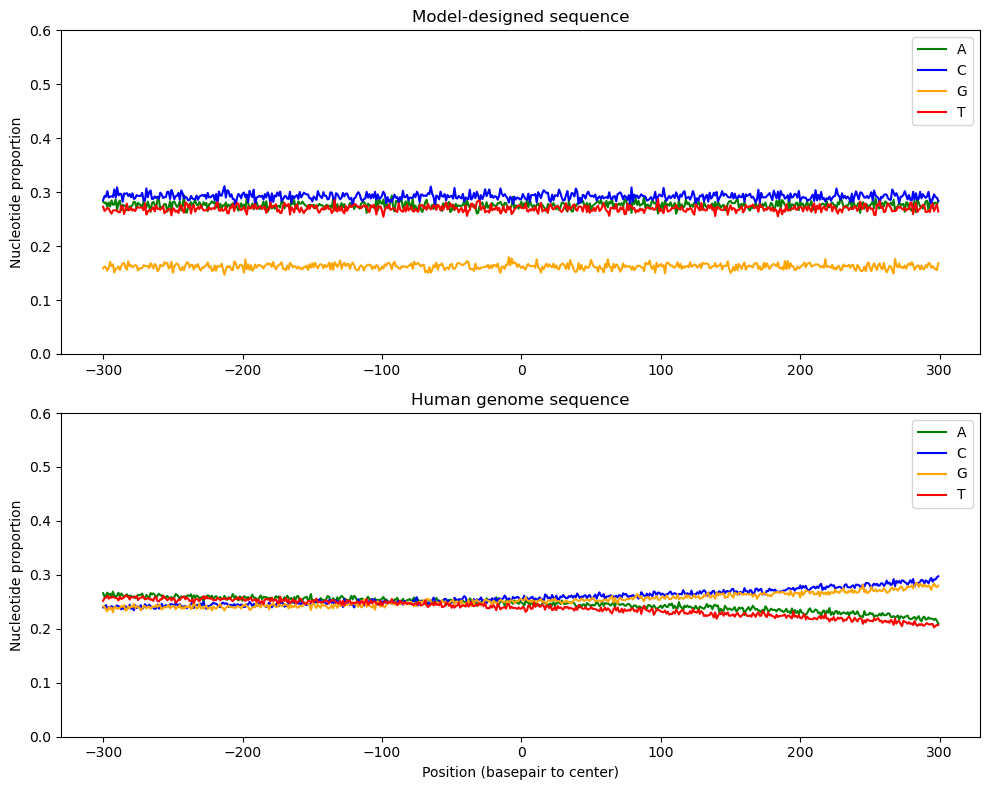

In [16]:
fig = plot_nucleotide_proportions(gt, model, range(-300, 300))
plt.show()

In [21]:
import re
motifs = {
     
            "TATA-box": re.compile("TATA[AT]A[AT]"),
            "GC-box": re.compile("GGGCGG"),
            "CCAAT-box": re.compile("CCAAT")
        }
def calculate_motif_frequency(sequences, window=1000):
        """Calculate motif frequency across positions"""
        center = len(sequences[0]) // 2
        half_window = window // 2
        bins = np.arange(-half_window, half_window + 1, 10)  # 10bp bins
        
        # Initialize data structure
        motif_counts = {motif: np.zeros(len(bins)-1) for motif in motifs}
        
        # Count motifs in each position bin
        for  sequence in sequences:
            for motif_name, motif_pattern in motifs.items():
                for match in motif_pattern.finditer(sequence):
                    # Calculate center position of the motif
                    motif_center = match.start() + len(match.group()) // 2
                    # Position relative to sequence center
                    relative_pos = motif_center - center
                    
                    # Find the bin
                    if -half_window <= relative_pos < half_window:
                        bin_idx = np.digitize(relative_pos, bins) - 1
                        if 0 <= bin_idx < len(motif_counts[motif_name]):
                            motif_counts[motif_name][bin_idx] += 1
        
        # Convert to frequency (normalize by number of sequences and bin width)
        for motif in motif_counts:
            motif_counts[motif] = motif_counts[motif] / (len(sequences) * 10)
            
        return motif_counts, bins[:-1] + 5

In [28]:
def plot_motif_frequency(ref_motifs, model_motifs, bin_centers):
        """
        Plot motif frequency distributions (similar to panel c)
        """
        plt.figure(figsize=(12, 8))
        motif_names = list(ref_motifs.keys())
        colors = ['red', 'orange', 'green']
        
        # Plot motifs for model sequences
        for i, motif in enumerate(motif_names):
            plt.subplot(2, 3, i+1)
            plt.plot(bin_centers, model_motifs[motif], color=colors[i])
            max_val = max(model_motifs[motif].max(), ref_motifs[motif].max()) * 1.1
            plt.ylim(0, max_val)
            if i == 0:
                plt.title("Model-designed sequence\n" + motif)
            else:
                plt.title(motif)
            plt.xlabel("Position (basepair to center)")
            plt.ylabel("Motif frequency")
        
        # Plot motifs for reference sequences
        for i, motif in enumerate(motif_names):
            plt.subplot(2, 3, i+4)
            plt.plot(bin_centers, ref_motifs[motif], color=colors[i])
            max_val = max(model_motifs[motif].max(), ref_motifs[motif].max()) * 1.1
            plt.ylim(0, max_val)
            if i == 0:
                plt.title("Human genome sequence\n" + motif)
            else:
                plt.title(motif)
            plt.xlabel("Position (basepair to center)")
            plt.ylabel("Motif frequency")
        
        plt.tight_layout()
        return plt.gcf()

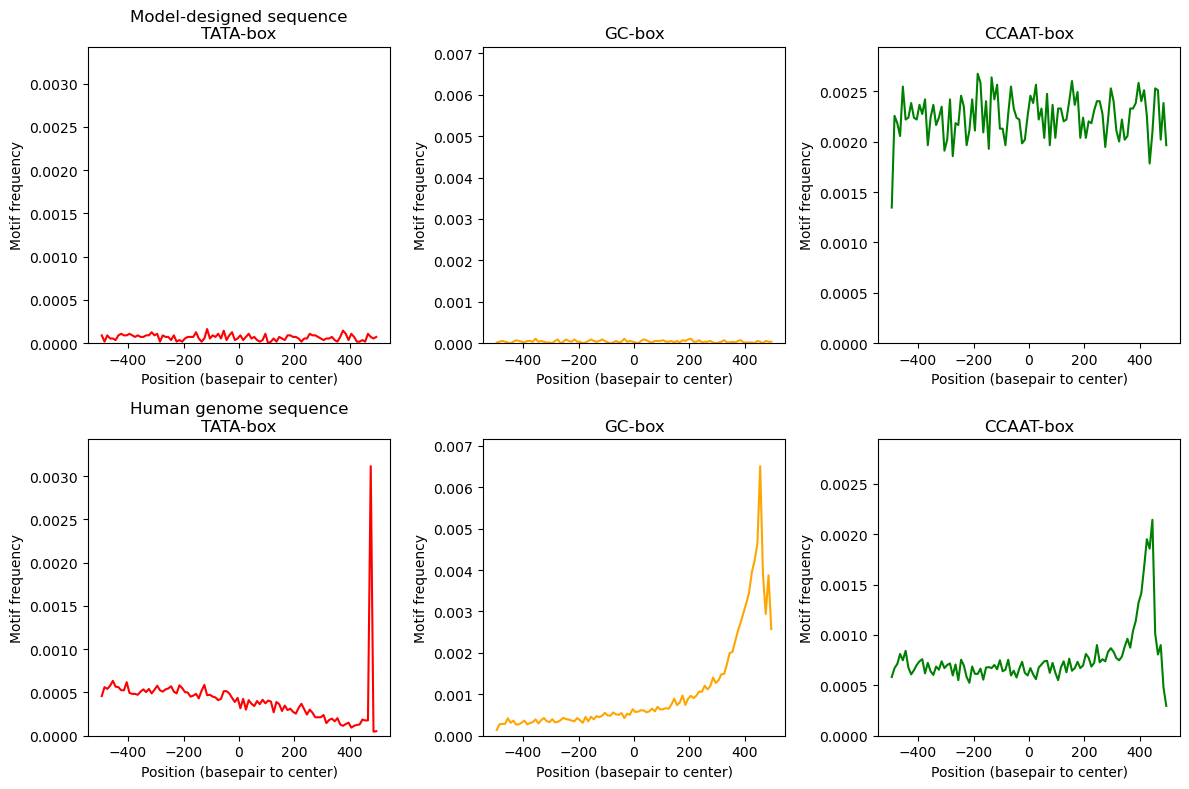

In [29]:
model_motifs, bin_centers = calculate_motif_frequency(seqs)
ref_motifs, _ = calculate_motif_frequency(queries)
fig = plot_motif_frequency(ref_motifs=ref_motifs, model_motifs=model_motifs, bin_centers=bin_centers)
plt.show()

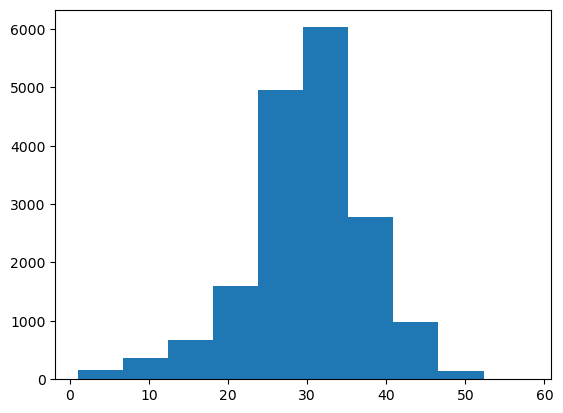

In [ ]:
with open("/n/groups/marks/users/erik/Promoter_Poet_private/logs/train_distribution.pkl", "rb") as f:
    distribution = pickle.load(f)

plt.figure()
plt.hist()
plt.show()

In [5]:
distribution.values()

dict_values([34, 33, 35, 25, 42, 37, 40, 30, 24, 16, 41, 37, 32, 32, 34, 24, 34, 29, 31, 33, 8, 42, 35, 45, 39, 37, 25, 36, 30, 25, 26, 38, 27, 36, 41, 36, 37, 35, 49, 31, 33, 40, 29, 36, 30, 34, 28, 35, 33, 48, 33, 39, 36, 33, 32, 35, 36, 31, 48, 28, 27, 20, 33, 41, 35, 39, 28, 28, 36, 24, 32, 28, 30, 36, 31, 34, 33, 26, 27, 37, 44, 32, 34, 30, 31, 34, 32, 38, 34, 41, 36, 39, 34, 28, 32, 39, 33, 40, 32, 29, 33, 33, 41, 36, 31, 34, 29, 35, 31, 34, 37, 29, 23, 33, 33, 42, 29, 25, 33, 38, 40, 38, 31, 37, 31, 30, 22, 40, 22, 18, 28, 12, 37, 19, 43, 29, 35, 30, 35, 26, 34, 41, 30, 47, 33, 41, 33, 38, 30, 25, 38, 38, 28, 35, 30, 44, 35, 42, 34, 34, 34, 29, 28, 30, 41, 30, 28, 32, 36, 37, 31, 14, 29, 35, 42, 35, 33, 38, 31, 42, 45, 32, 27, 40, 41, 43, 26, 35, 36, 33, 37, 33, 29, 36, 37, 33, 31, 36, 36, 37, 29, 17, 41, 34, 36, 28, 33, 32, 44, 31, 25, 35, 22, 16, 25, 26, 37, 35, 22, 17, 40, 37, 41, 32, 31, 36, 28, 39, 23, 44, 35, 15, 47, 35, 24, 40, 30, 28, 28, 27, 21, 33, 30, 25, 47, 18, 41, 

In [2]:
df_path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/scored_sanity_check.csv"
df = pd.read_csv(df_path)

hits_path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/hits.pkl"
with open(hits_path, "rb") as f:
    hits = pickle.load(f)

def get_count(x):
    if x in hits:
        return len(hits[x])
    else:
        return None

df['count'] = df['GENE'].map(get_count)



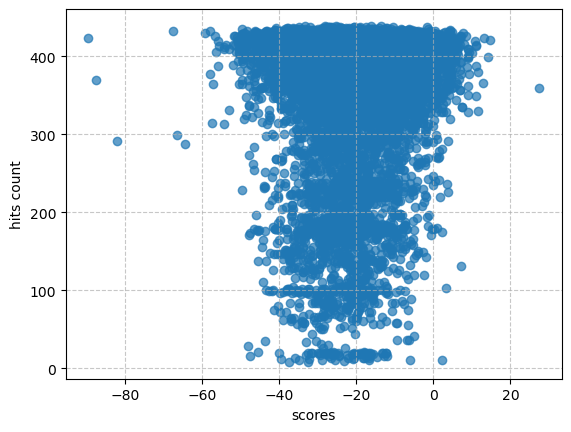

In [3]:
plt.figure()
plt.scatter(df['WT_scores'], df['count'], alpha=0.7)
# Add labels and title
plt.xlabel('scores')
plt.ylabel('hits count')
# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()